In [716]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [717]:
df = pd.read_csv('Datos_de_calidad_del_agua_2020/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_superficiales_2020.csv', encoding='latin-1')

# Proceso de limpieza inicial

In [718]:

df = df.dropna(how='all')
df = df.replace(['ND', ''], np.nan)
df = df.drop([
  'TOX_D_48_FON_UT', 
  'CALIDAD_TOX_D_48_FON', 
  'TOX_FIS_FON_15_UT', 
  'CALIDAD_TOX_FIS_FON_15', 
  'PERIODO'
], axis=1)

cols_menor_que = [
  'DBO_mg/L', 'DQO_mg/L', 'SST_mg/L', 'E_COLI_NMP_100mL', 
  'ENTEROC_NMP_100mL', 'OD_PORC', 'OD_PORC_SUP', 'OD_PORC_MED', 
  'OD_PORC_FON', 'TOX_D_48_UT', 'TOX_V_15_UT', 'TOX_D_48_SUP_UT', 'TOX_FIS_SUP_15_UT',
  'COLI_FEC_NMP_100mL'
]
df[cols_menor_que] = df[cols_menor_que].replace({'<1':0.9, '<2':1.9, '<3': 2.9, '<10': 9.9})

cols_si_no = [
  'CUMPLE_CON_DBO', 'CUMPLE_CON_DQO', 'CUMPLE_CON_SST', 'CUMPLE_CON_CF',
  'CUMPLE_CON_E_COLI', 'CUMPLE_CON_ENTEROC', 'CUMPLE_CON_OD', 'CUMPLE_CON_TOX',
]
df[cols_si_no] = df[cols_si_no].replace({'SI':1, 'NO':0})

cols_calidad = [
  'CALIDAD_COLI_FEC', 
  'CALIDAD_DBO', 
  'CALIDAD_DQO', 
  'CALIDAD_E_COLI', 
  'CALIDAD_ENTEROC', 
  'CALIDAD_OD_PORC', 
  'CALIDAD_OD_PORC_FON', 
  'CALIDAD_OD_PORC_MED', 
  'CALIDAD_OD_PORC_SUP', 
  'CALIDAD_SST', 
]
df[cols_calidad] = df[cols_calidad].replace({
  'Excelente': 5,
  'Buena calidad': 4,
  'Aceptable': 3,
  'Contaminada': 2,
  'Fuertemente contaminada': 1,
})

cols_toxicidad = [
  'CALIDAD_TOX_D_48',
  'CALIDAD_TOX_V_15',
  'CALIDAD TOX_D_48_SUP',
  'CALIDAD_TOX_FIS_SUP_15',
]

df[cols_toxicidad] = df[cols_toxicidad].replace({
  'No Toxico' : 1 ,
  'Toxicidad baja' : 2,
  'Toxicidad moderada' : 3 ,
  'Toxicidad alta' : 4,
})

flotantes = [
  'DBO_mg/L', 'DQO_mg/L', 'SST_mg/L', 'E_COLI_NMP_100mL', 
  'ENTEROC_NMP_100mL', 'OD_PORC', 'OD_PORC_SUP', 'OD_PORC_MED', 
  'OD_PORC_FON', 'TOX_D_48_UT', 'TOX_V_15_UT', 'TOX_D_48_SUP_UT', 'TOX_FIS_SUP_15_UT',
  'COLI_FEC_NMP_100mL'
]
df[flotantes] = df[flotantes].astype(float)

# label encoder para las columnas de texto
le = LabelEncoder()
df['TIPO'] = le.fit_transform(df['TIPO'])
df['SUBTIPO'] = le.fit_transform(df['SUBTIPO'])
df['GRUPO'] = le.fit_transform(df['GRUPO'])

In [719]:
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values(ascending=False)


CALIDAD_OD_PORC_MED       86.057830
OD_PORC_MED               86.057830
CALIDAD TOX_D_48_SUP      78.184941
TOX_D_48_SUP_UT           78.184941
ENTEROC_NMP_100mL         74.119668
CUMPLE_CON_ENTEROC        74.119668
CALIDAD_ENTEROC           74.119668
CALIDAD_OD_PORC_FON       72.917263
OD_PORC_FON               72.917263
OD_PORC_SUP               53.650157
CALIDAD_OD_PORC_SUP       53.650157
TOX_FIS_SUP_15_UT         52.075580
CALIDAD_TOX_FIS_SUP_15    52.075580
OD_PORC                   48.554251
CALIDAD_OD_PORC           48.554251
CALIDAD_TOX_D_48          48.010306
TOX_D_48_UT               48.010306
CALIDAD_TOX_V_15          47.924420
TOX_V_15_UT               47.924420
CONTAMINANTES             36.272545
DQO_mg/L                  26.109362
CALIDAD_DQO               26.109362
CUMPLE_CON_DBO            26.109362
CUMPLE_CON_DQO            26.109362
DBO_mg/L                  26.109362
CALIDAD_DBO               26.109362
CALIDAD_E_COLI            26.080733
CUMPLE_CON_CF             26

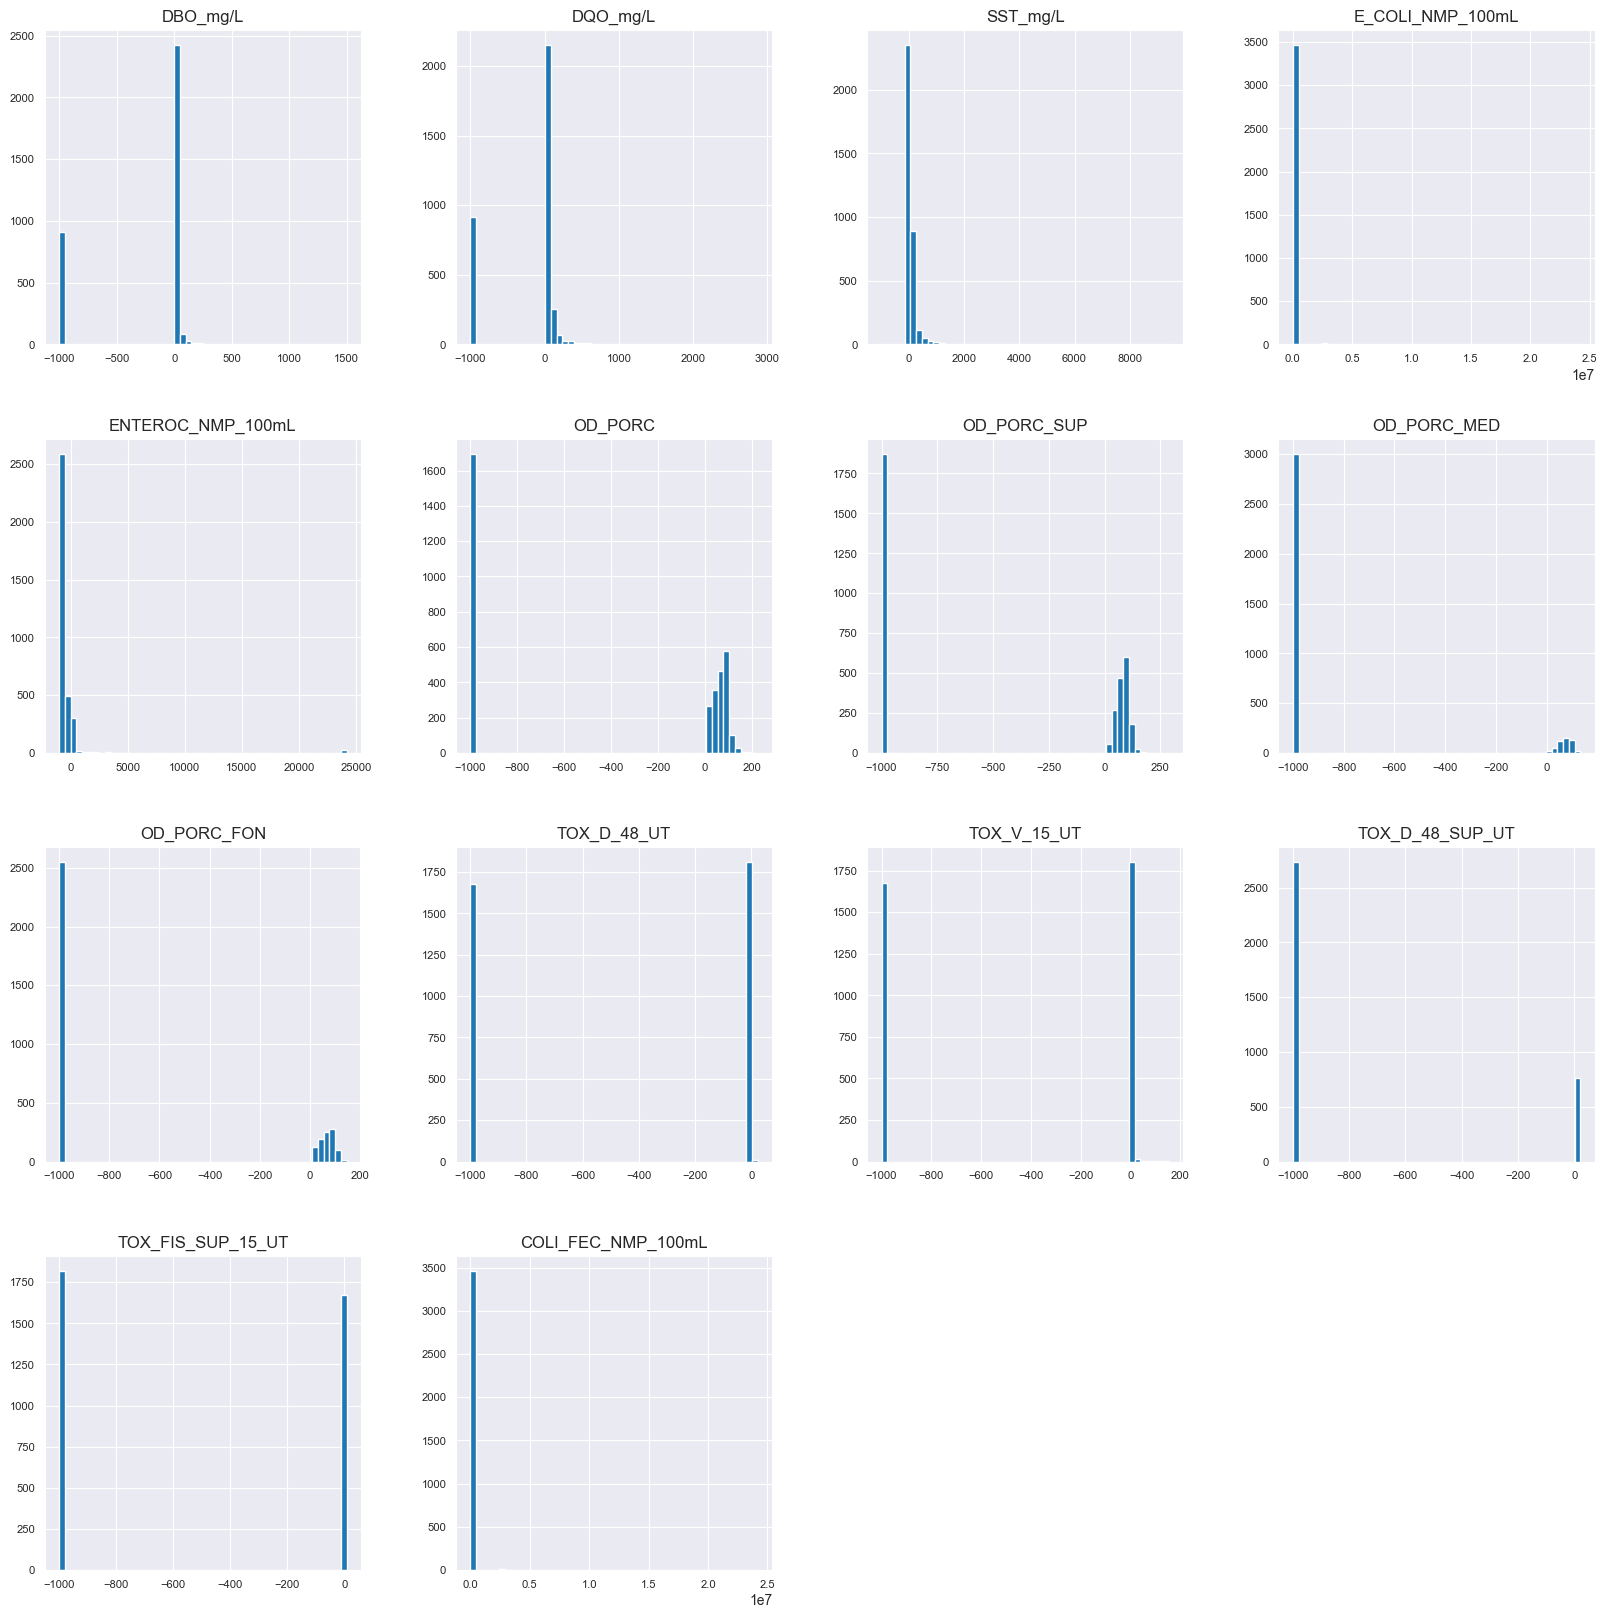

In [720]:
numericas_continuas = [ 
  'DBO_mg/L', 
  'DQO_mg/L', 
  'SST_mg/L', 
  'E_COLI_NMP_100mL', 
  'ENTEROC_NMP_100mL', 
  'OD_PORC', 
  'OD_PORC_SUP', 
  'OD_PORC_MED', 
  'OD_PORC_FON', 
  'TOX_D_48_UT', 
  'TOX_V_15_UT', 
  'TOX_D_48_SUP_UT', 
  'TOX_FIS_SUP_15_UT',
  'COLI_FEC_NMP_100mL'
]
num = df[numericas_continuas]
num = num.fillna(-1000)

num.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [721]:
# drop columns with more than 50% missing values
more_than_50_missing = percent_missing[percent_missing > 50].index
print(more_than_50_missing.shape)
df = df.drop(more_than_50_missing, axis=1)

(13,)


In [722]:
categoricas_numericas = [
  'TIPO',
  'SUBTIPO',
  'GRUPO',

  'CUMPLE_CON_DBO', 
  'CUMPLE_CON_DQO', 
  'CUMPLE_CON_SST', 
  'CUMPLE_CON_CF',
  'CUMPLE_CON_E_COLI', 
  # 'CUMPLE_CON_ENTEROC', 
  'CUMPLE_CON_OD', 
  'CUMPLE_CON_TOX',
]
numericas_discretas = [
  'CALIDAD_COLI_FEC', 
  'CALIDAD_DBO', 
  'CALIDAD_DQO', 
  'CALIDAD_E_COLI', 
  # 'CALIDAD_ENTEROC', 
  'CALIDAD_OD_PORC', 
  # 'CALIDAD_OD_PORC_FON', 
  # 'CALIDAD_OD_PORC_MED', 
  # 'CALIDAD_OD_PORC_SUP', 
  'CALIDAD_SST', 
  'CALIDAD_TOX_D_48',
  'CALIDAD_TOX_V_15',
  # 'CALIDAD TOX_D_48_SUP',
  # 'CALIDAD_TOX_FIS_SUP_15',
]

numericas_continuas = [ 
  'DBO_mg/L', 
  'DQO_mg/L', 
  'SST_mg/L', 
  'E_COLI_NMP_100mL', 
  # 'ENTEROC_NMP_100mL', 
  'OD_PORC', 
  # 'OD_PORC_SUP', 
  # 'OD_PORC_MED', 
  # 'OD_PORC_FON', 
  'TOX_D_48_UT', 
  'TOX_V_15_UT', 
  # 'TOX_D_48_SUP_UT', 
  # 'TOX_FIS_SUP_15_UT',
  'COLI_FEC_NMP_100mL'
]


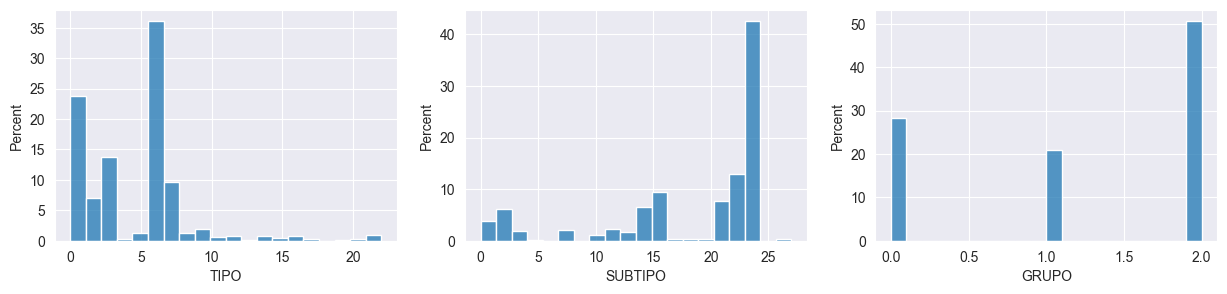

In [723]:
tipos = df[['TIPO', 'SUBTIPO', 'GRUPO']]
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
for k, col in enumerate(tipos.columns):  
  sns.histplot(tipos[col], ax=ax[k]  , stat='percent', multiple='layer', bins=20)

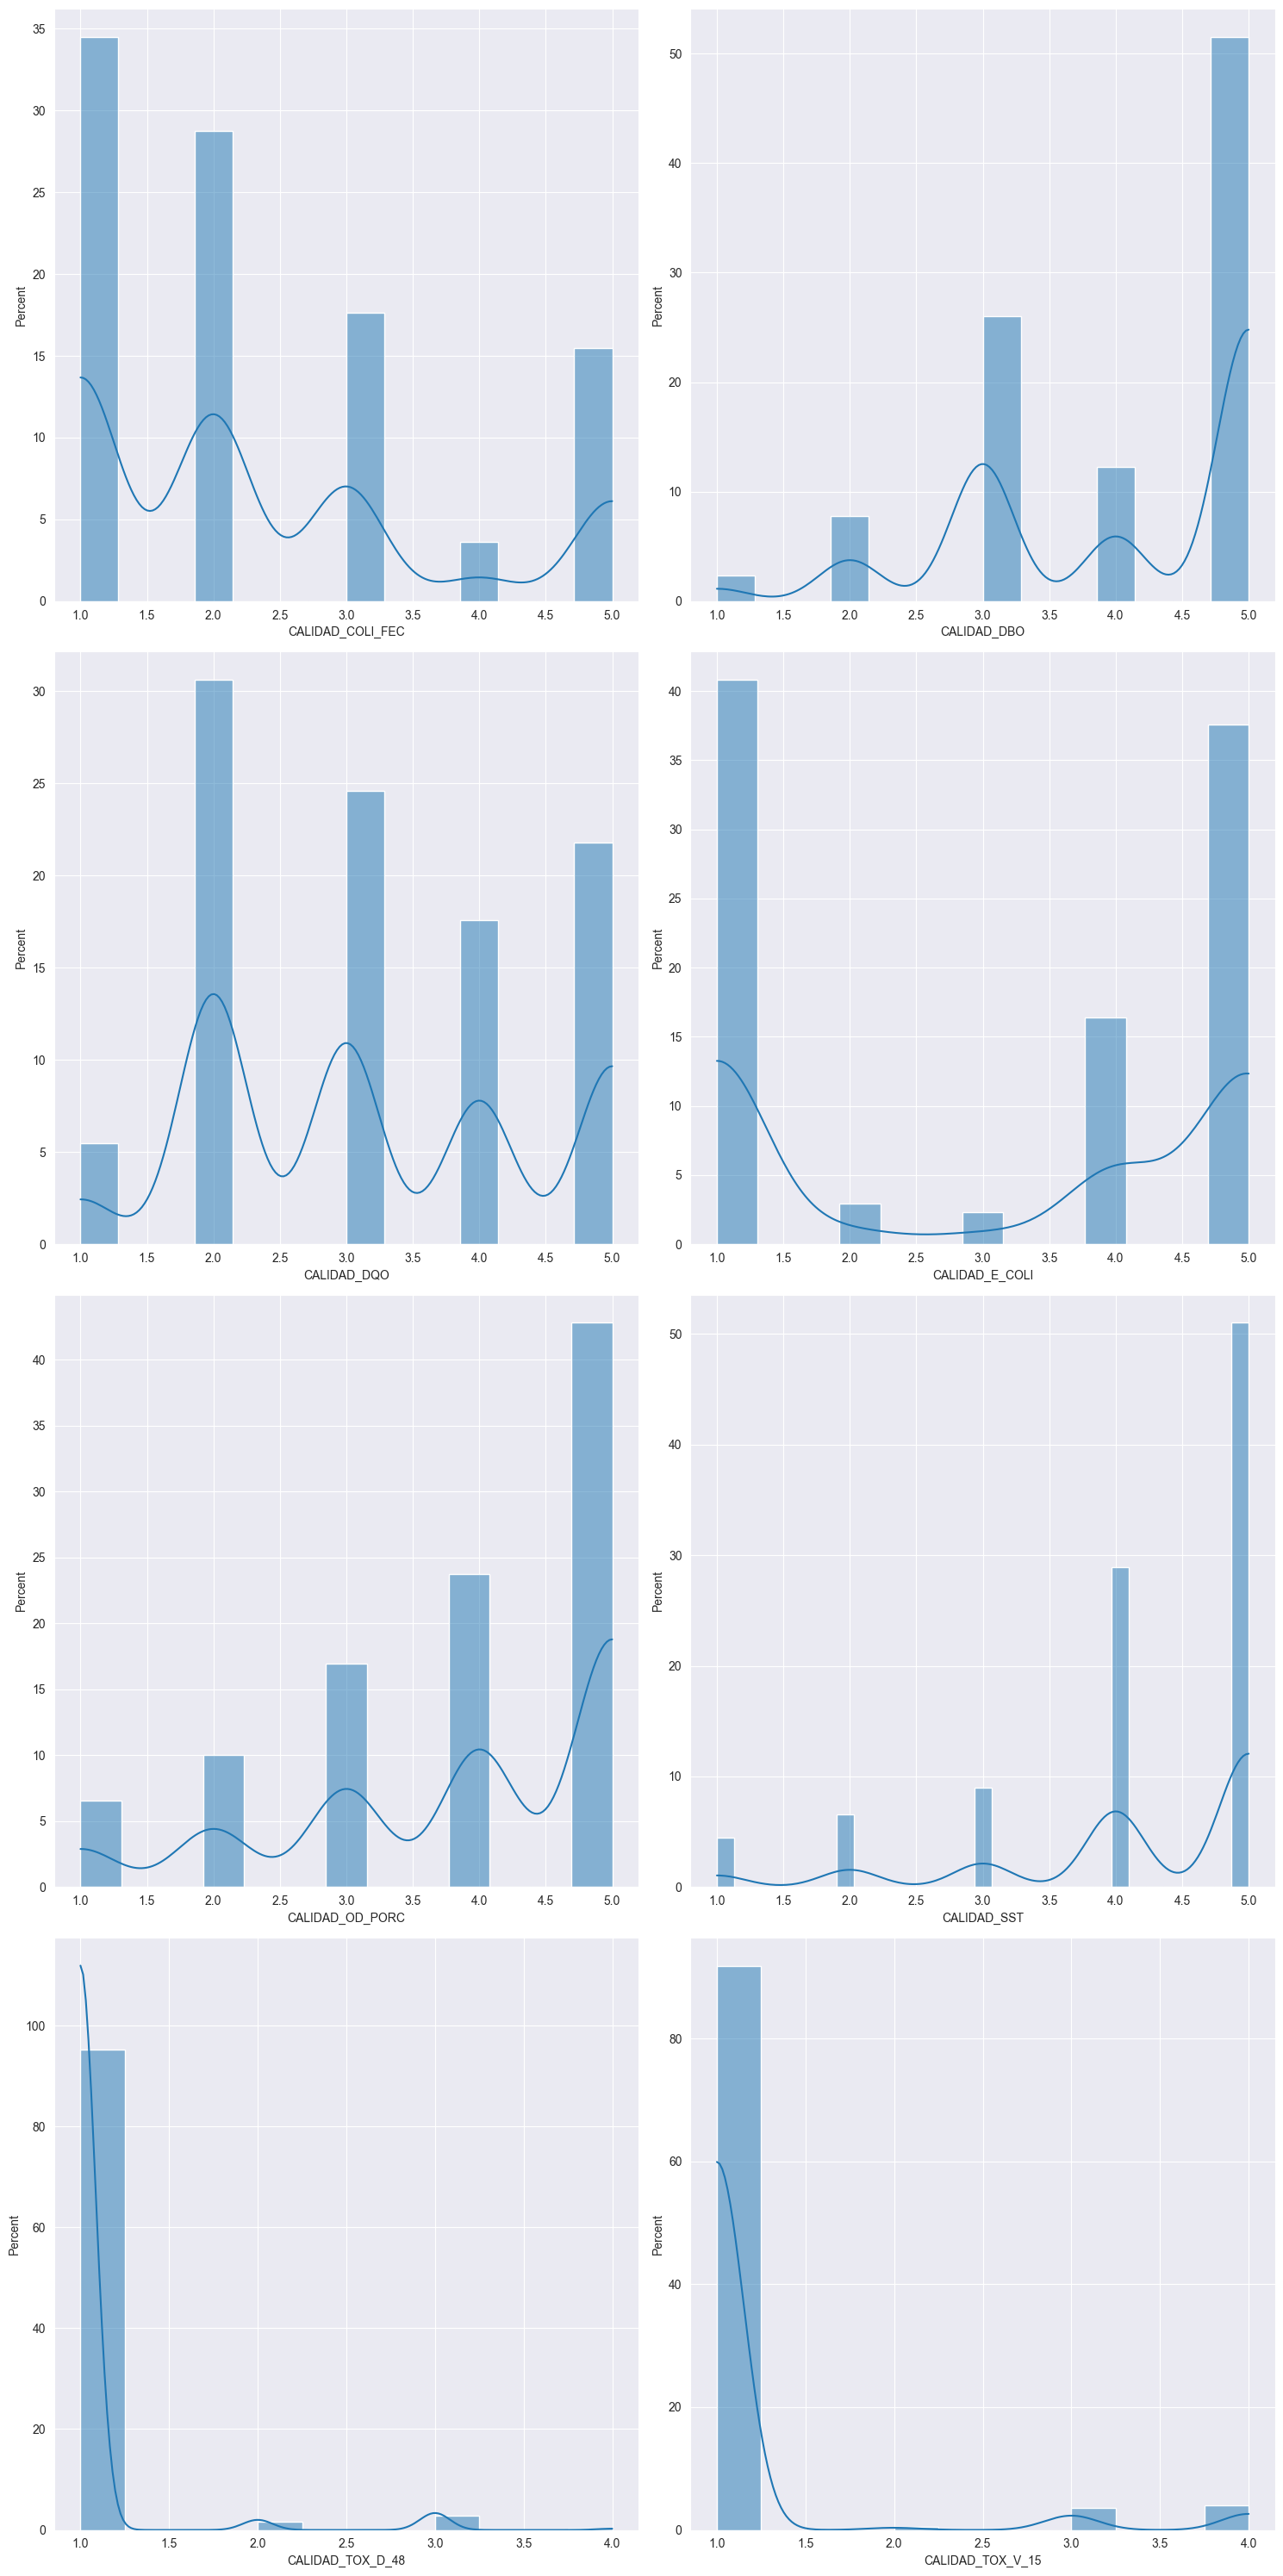

In [724]:
fig, ax = plt.subplots(4, 2, figsize=(15, 30))
for k, v in enumerate(numericas_discretas):
  sns.histplot(df[v], ax=ax[k//2, k%2], kde=True, stat='percent')

plt.tight_layout()

In [725]:
# fig, ax = plt.subplots(7, 2, figsize=(15, 20))
# for k, v in enumerate(numericas_continuas):
#   sns.histplot(df[v], ax=ax[k//2, k%2], kde=True)

# plt.tight_layout()

# sns.pairplot(df[numericas_continuas], diag_kind='kde', corner=True)

array([[<AxesSubplot: title={'center': 'DBO_mg/L'}>,
        <AxesSubplot: title={'center': 'DQO_mg/L'}>,
        <AxesSubplot: title={'center': 'SST_mg/L'}>],
       [<AxesSubplot: title={'center': 'E_COLI_NMP_100mL'}>,
        <AxesSubplot: title={'center': 'OD_PORC'}>,
        <AxesSubplot: title={'center': 'TOX_D_48_UT'}>],
       [<AxesSubplot: title={'center': 'TOX_V_15_UT'}>,
        <AxesSubplot: title={'center': 'COLI_FEC_NMP_100mL'}>,
        <AxesSubplot: >]], dtype=object)

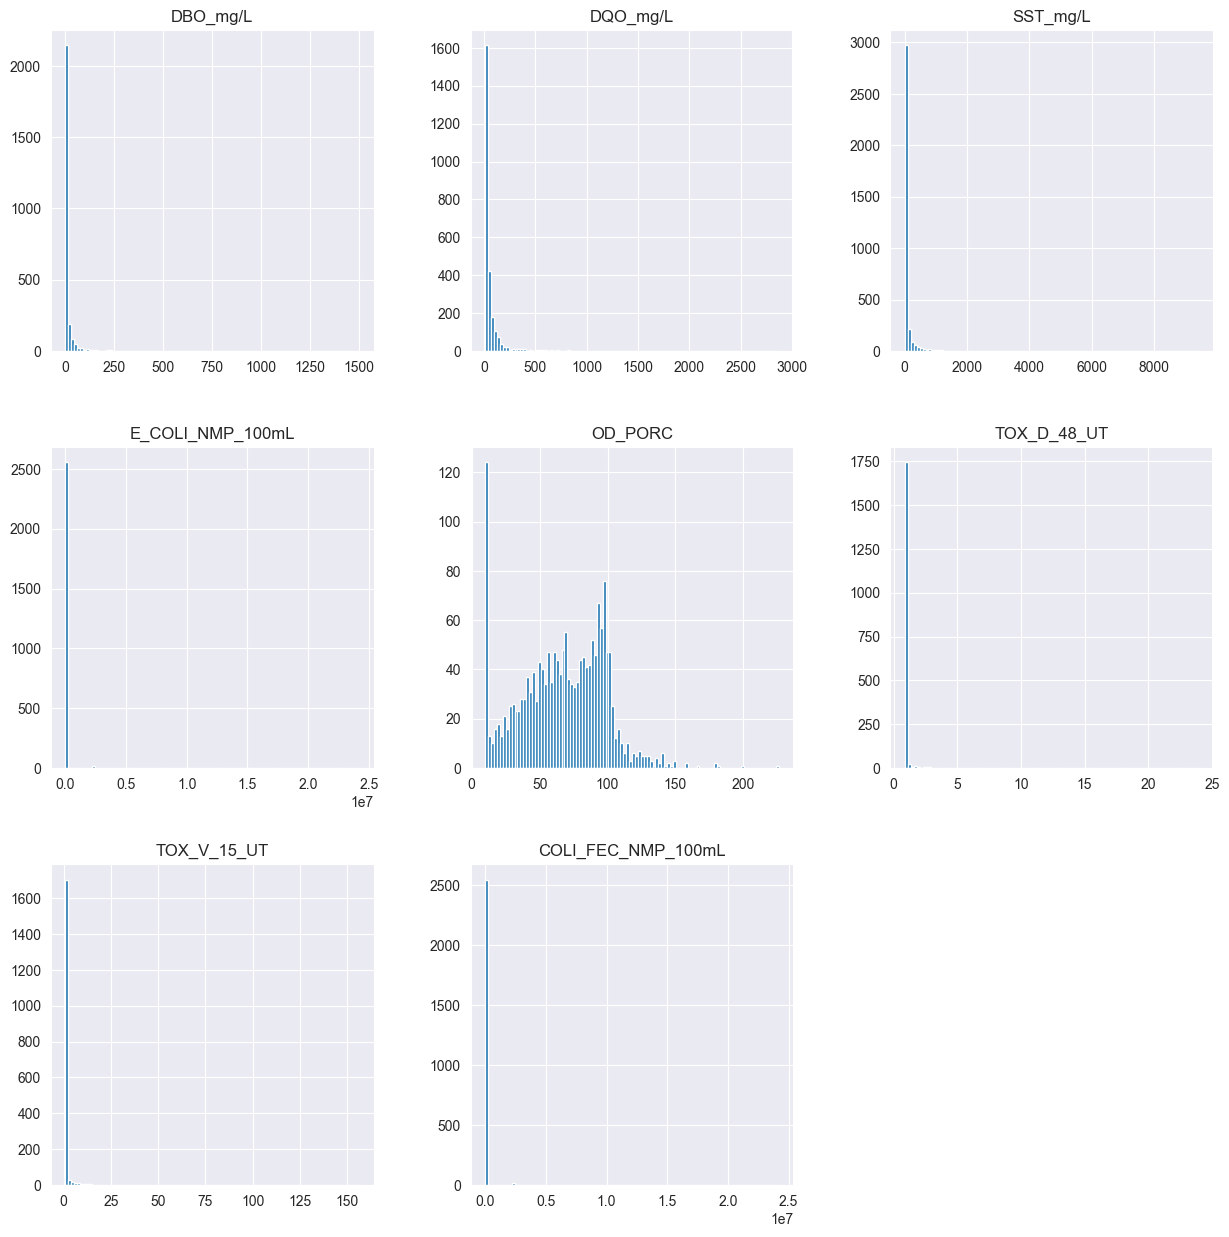

In [726]:
df[numericas_continuas].hist(figsize=(15, 15), bins=100)

In [727]:
# from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer, RobustScaler, MinMaxScaler

# scaler = StandardScaler()
# powert = PowerTransformer()
# quant = QuantileTransformer()
# robust = RobustScaler()
# minmax = MinMaxScaler(feature_range=(1, 2))

# fig, ax = plt.subplots(8, 7, figsize=(40, 40))
# for k, v in enumerate(numericas_continuas):
#   original = df[v]
#   scaled = scaler.fit_transform(df[[v]])
#   powerted = powert.fit_transform(df[[v]])
#   quantiled = quant.fit_transform(df[[v]])
#   robusted = robust.fit_transform(df[[v]])
#   minmaxed = minmax.fit_transform(df[[v]])

#   ax[k, 0].hist(original, bins=100)
#   ax[k, 0].set_title(v)
#   ax[k, 0].set_xlabel('original')

#   ax[k, 1].hist(scaled, bins=100)
#   ax[k, 1].set_title(v)
#   ax[k, 1].set_xlabel('StandardScaler')
  
#   ax[k, 2].hist(np.log(1 + original), bins=100)
#   ax[k, 2].set_title(v)
#   ax[k, 2].set_xlabel('log(1 + original)')

#   ax[k, 3].hist(powerted, bins=100)
#   ax[k, 3].set_title(v)
#   ax[k, 3].set_xlabel('PowerTransformer')

#   ax[k, 4].hist(quantiled, bins=100)
#   ax[k, 4].set_title(v)
#   ax[k, 4].set_xlabel('QuantileTransformer')

#   ax[k, 5].hist(robusted, bins=100)
#   ax[k, 5].set_title(v)
#   ax[k, 5].set_xlabel('RobustScaler')

#   ax[k, 6].hist(minmaxed, bins=100)
#   ax[k, 6].set_title(v)
#   ax[k, 6].set_xlabel('MinMaxScaler')


# plt.tight_layout()
# plt.show()



# Selecciona tus variables independientes X y dependiente Y (semáforo)

In [728]:
df.columns
X = df[[
  'TIPO', 'SUBTIPO', 'LONGITUD', 'LATITUD',
  'DBO_mg/L', 'CALIDAD_DBO', 'DQO_mg/L', 'CALIDAD_DQO', 'SST_mg/L',
  'CALIDAD_SST', 'COLI_FEC_NMP_100mL', 'CALIDAD_COLI_FEC',
  'E_COLI_NMP_100mL', 'CALIDAD_E_COLI', 'OD_PORC', 'CALIDAD_OD_PORC',
  'TOX_D_48_UT', 'CALIDAD_TOX_D_48', 'TOX_V_15_UT', 'CALIDAD_TOX_V_15',
  'CUMPLE_CON_DBO', 'CUMPLE_CON_DQO',
  'CUMPLE_CON_SST', 'CUMPLE_CON_CF', 'CUMPLE_CON_E_COLI', 'CUMPLE_CON_OD',
  'CUMPLE_CON_TOX', 'GRUPO'
]]

y = df['SEMAFORO']
print(X.shape)
print(y.shape)





(3493, 28)
(3493,)


# Cambia a one hot encoding el semáforo


In [729]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
yfinal = ohe.fit_transform(y.values.reshape(-1, 1))
print(yfinal.shape)

(3493, 3)


# Realiza un análisis general de las features importances a traves de decision trees o random forest.


numéricas discretas

calidad_coli_fec el caso 4 hay que cambiarlo a  3, 4 => 3

calidad_dbo el 2 lo agrupamos con el 1  2 => 1

calidad_ecoli 2 y 3 lo agrupamos con el 1 o dejarlas en 1 

calidad_sst 3, 2, 1 => 2

calidad_tox 2, 3, 4 => 3

calidad_tox_v_15  2, 3, 4 => 3

**NOTA** Revisar como agrupar los valores de tipo, subtipo y grupo

In [730]:
# Funciones a utilizar en el pipeline
def reemplazos(x):
  reemplazos = {
    'CALIDAD_COLI_FEC': {1:1, 2:2, 3:3, 4:3, 5:5},
    'CALIDAD_DBO':      {1:1, 2:1, 3:3, 4:4, 5:5},
    'CALIDAD_E_COLI':   {1:1, 2:1, 3:1, 4:4, 5:5},
    'CALIDAD_SST':      {1:2, 2:2, 3:2, 4:4, 5:5},
    'CALIDAD_TOX_D_48': {1:1, 2:2, 3:3, 4:3},
    'CALIDAD_TOX_V_15': {1:1, 2:2, 3:3, 4:3},
  }
  for column, replacements in reemplazos.items():
    x[column] = x[column].map(replacements)

  return x
  

def log_transform(x):
  return np.log(1 + x)


In [731]:
import warnings
import sklearn
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [732]:
numeric_pipe = Pipeline(steps=[
  ('numeric_imputer', SimpleImputer(strategy='median')),
  ('numeric_scaler', FunctionTransformer(log_transform)),
])
numericas_continuas = [ 
  'DBO_mg/L', 
  'DQO_mg/L', 
  'SST_mg/L', 
  'E_COLI_NMP_100mL', 
  'OD_PORC', 
  'TOX_D_48_UT', 
  'TOX_V_15_UT', 
  'COLI_FEC_NMP_100mL'
]

most_frequent_pipeline = Pipeline(steps=[
  ('mode_imputer', SimpleImputer(strategy='most_frequent')),
])
numericas_discretas = [
  'CALIDAD_DQO', 
  'CALIDAD_OD_PORC', 
  'TIPO',
  'SUBTIPO',
  'GRUPO',
  'CUMPLE_CON_DBO', 
  'CUMPLE_CON_DQO', 
  'CUMPLE_CON_SST', 
  'CUMPLE_CON_CF',
  'CUMPLE_CON_E_COLI', 
  'CUMPLE_CON_OD', 
  'CUMPLE_CON_TOX',
  'LATITUD',
  'LONGITUD',
]

reemplazos_pipe = Pipeline(steps=[
  # ('reemplazos_map', FunctionTransformer(reemplazos)),
  ('mode_imputer', SimpleImputer(strategy='most_frequent')),
])
reemplazos = [
  'CALIDAD_COLI_FEC', 
  'CALIDAD_DBO', 
  'CALIDAD_E_COLI', 
  'CALIDAD_SST', 
  'CALIDAD_TOX_D_48', 
  'CALIDAD_TOX_V_15'
]
              
columnTransformer = ColumnTransformer(
  transformers=[
    ('reemplazos', reemplazos_pipe, reemplazos),
    ('numeric', numeric_pipe, numericas_continuas),    
    ('most_frequent', most_frequent_pipeline, numericas_discretas),
  ],
  remainder='passthrough'
)



In [733]:
len(X.columns)

28

In [734]:
Xtransformed = columnTransformer.fit_transform(X)


In [735]:
feature_names = get_feature_names(columnTransformer)
feature_names

/var/folders/3d/g1jyg89x1lddp3_14lxcz1g40000gn/T/ipykernel_2828/3914210993.py:32: UserWarning: Transformer mode_imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
/var/folders/3d/g1jyg89x1lddp3_14lxcz1g40000gn/T/ipykernel_2828/3914210993.py:32: UserWarning: Transformer numeric_imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
/var/folders/3d/g1jyg89x1lddp3_14lxcz1g40000gn/T/ipykernel_2828/3914210993.py:32: UserWarning: Transformer numeric_scaler (type FunctionTransformer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


['reemplazos__CALIDAD_COLI_FEC',
 'reemplazos__CALIDAD_DBO',
 'reemplazos__CALIDAD_E_COLI',
 'reemplazos__CALIDAD_SST',
 'reemplazos__CALIDAD_TOX_D_48',
 'reemplazos__CALIDAD_TOX_V_15',
 'numeric__DBO_mg/L',
 'numeric__DQO_mg/L',
 'numeric__SST_mg/L',
 'numeric__E_COLI_NMP_100mL',
 'numeric__OD_PORC',
 'numeric__TOX_D_48_UT',
 'numeric__TOX_V_15_UT',
 'numeric__COLI_FEC_NMP_100mL',
 'most_frequent__CALIDAD_DQO',
 'most_frequent__CALIDAD_OD_PORC',
 'most_frequent__TIPO',
 'most_frequent__SUBTIPO',
 'most_frequent__GRUPO',
 'most_frequent__CUMPLE_CON_DBO',
 'most_frequent__CUMPLE_CON_DQO',
 'most_frequent__CUMPLE_CON_SST',
 'most_frequent__CUMPLE_CON_CF',
 'most_frequent__CUMPLE_CON_E_COLI',
 'most_frequent__CUMPLE_CON_OD',
 'most_frequent__CUMPLE_CON_TOX',
 'most_frequent__LATITUD',
 'most_frequent__LONGITUD']

In [736]:
XTransDf = pd.DataFrame(Xtransformed, columns=feature_names)
XTransDf.describe(include='all').T


,count,mean,std,min,25%,50%,75%,max
reemplazos__CALIDAD_COLI_FEC,3493.0,2.010593,1.334687,1.000000,1.000000,1.000000,3.000000,5.000000
reemplazos__CALIDAD_DBO,3493.0,4.281993,1.068828,1.000000,3.000000,5.000000,5.000000,5.000000
reemplazos__CALIDAD_E_COLI,3493.0,2.529917,1.812054,1.000000,1.000000,1.000000,5.000000,5.000000
reemplazos__CALIDAD_SST,3493.0,4.156026,1.113281,1.000000,4.000000,5.000000,5.000000,5.000000
reemplazos__CALIDAD_TOX_D_48,3493.0,1.042084,0.277452,1.000000,1.000000,1.000000,1.000000,4.000000
reemplazos__CALIDAD_TOX_V_15,3493.0,1.102777,0.504874,1.000000,1.000000,1.000000,1.000000,4.000000
numeric__DBO_mg/L,3493.0,1.719344,0.967028,1.064711,1.064711,1.289233,2.048982,7.313887
numeric__DQO_mg/L,3493.0,3.443151,0.866430,2.388763,2.875822,3.332562,3.775516,7.962851
numeric__SST_mg/L,3493.0,3.497709,1.168404,2.388763,2.388763,3.230804,4.060443,9.151757
numeric__E_COLI_NMP_100mL,3493.0,6.087476,2.785559,1.360977,4.510860,6.052089,7.783641,17.001698


In [737]:
SEED = 42

In [738]:
testingX = X.copy()

numericas_continuas = [ 
  'DBO_mg/L', 
  'DQO_mg/L', 
  'SST_mg/L', 
  'E_COLI_NMP_100mL', 
  'OD_PORC', 
  'TOX_D_48_UT', 
  'TOX_V_15_UT', 
  'COLI_FEC_NMP_100mL'
]

numericas_discretas = [
  'CALIDAD_DQO', 
  'CALIDAD_OD_PORC', 
  'TIPO',
  'SUBTIPO',
  'GRUPO',
  'CUMPLE_CON_DBO', 
  'CUMPLE_CON_DQO', 
  'CUMPLE_CON_SST', 
  'CUMPLE_CON_CF',
  'CUMPLE_CON_E_COLI', 
  'CUMPLE_CON_OD', 
  'CUMPLE_CON_TOX',
  'LATITUD',
  'LONGITUD',
]

reemplazos = [
  'CALIDAD_COLI_FEC', 
  'CALIDAD_DBO', 
  'CALIDAD_E_COLI', 
  'CALIDAD_SST', 
  'CALIDAD_TOX_D_48', 
  'CALIDAD_TOX_V_15'
]

for k, v in enumerate(reemplazos):
  mode = testingX[v].mode()
  testingX[v] = testingX[v].fillna(mode[0])
  
testingX[numericas_continuas] = testingX[numericas_continuas].fillna(testingX[numericas_continuas].median())
testingX[numericas_continuas] = testingX[numericas_continuas].apply(log_transform)

for k, v in enumerate(numericas_discretas):
  mode = testingX[v].mode()
  testingX[v] = testingX[v].fillna(mode[0])
# reemplazos = {
#   'CALIDAD_COLI_FEC': {1:1, 2:2, 3:3, 4:3, 5:5},
#   'CALIDAD_DBO':      {1:1, 2:1, 3:3, 4:4, 5:5},
#   'CALIDAD_E_COLI':   {1:1, 2:1, 3:1, 4:4, 5:5},
#   'CALIDAD_SST':      {1:2, 2:2, 3:2, 4:4, 5:5},
#   'CALIDAD_TOX_D_48': {1:1, 2:2, 3:3, 4:3},
#   'CALIDAD_TOX_V_15': {1:1, 2:2, 3:3, 4:3},
# }
# for column, replacements in reemplazos.items():
#   testingX[column] = testingX[column].map(replacements)

testingX.describe(include='all').T


,count,mean,std,min,25%,50%,75%,max
TIPO,3493.0,4.664472,3.649474,0.000000,2.000000,6.000000,6.000000,22.000000
SUBTIPO,3493.0,18.267678,7.592287,0.000000,14.000000,22.000000,24.000000,27.000000
LONGITUD,3493.0,-100.359969,6.122773,-117.124030,-103.882310,-99.795530,-96.860230,-86.732150
LATITUD,3493.0,21.046992,3.893696,14.534910,18.396070,20.148980,22.828930,32.706500
DBO_mg/L,3493.0,1.719344,0.967028,1.064711,1.064711,1.289233,2.048982,7.313887
CALIDAD_DBO,3493.0,4.281993,1.068828,1.000000,3.000000,5.000000,5.000000,5.000000
DQO_mg/L,3493.0,3.443151,0.866430,2.388763,2.875822,3.332562,3.775516,7.962851
CALIDAD_DQO,3493.0,2.883481,1.186935,1.000000,2.000000,2.000000,4.000000,5.000000
SST_mg/L,3493.0,3.497709,1.168404,2.388763,2.388763,3.230804,4.060443,9.151757
CALIDAD_SST,3493.0,4.156026,1.113281,1.000000,4.000000,5.000000,5.000000,5.000000


In [751]:
from sklearn.tree import export_graphviz

In [756]:
randomForest = RandomForestClassifier(
  n_estimators=100,
  max_depth=10,
  random_state=SEED,
  n_jobs=-1,
)

randomForest.fit(Xtransformed, yfinal)

feature_names = get_feature_names(columnTransformer)

feature_importances = pd.DataFrame(
  randomForest.feature_importances_, 
  index=feature_names,  
  columns=['importance']
).sort_values('importance', ascending=False)

feature_importances.head(14).sum()

estimator = randomForest.estimators_[5]
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = ['Verde', 'Amarillo', 'Rojo'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=200'])


/var/folders/3d/g1jyg89x1lddp3_14lxcz1g40000gn/T/ipykernel_2828/3914210993.py:32: UserWarning: Transformer mode_imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
/var/folders/3d/g1jyg89x1lddp3_14lxcz1g40000gn/T/ipykernel_2828/3914210993.py:32: UserWarning: Transformer numeric_imputer (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
/var/folders/3d/g1jyg89x1lddp3_14lxcz1g40000gn/T/ipykernel_2828/3914210993.py:32: UserWarning: Transformer numeric_scaler (type FunctionTransformer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


0

In [757]:
rndFrst = RandomForestClassifier(
  n_estimators=100,
  max_depth=10,
  random_state=SEED,
  n_jobs=-1,
)
rndFrst

rndFrst.fit(testingX, yfinal)

feature_importances = pd.DataFrame(
  rndFrst.feature_importances_, 
  index=testingX.columns,  
  columns=['importance']
).sort_values('importance', ascending=False)

feature_importances.head(14).sum()

estimator = rndFrst.estimators_[5]
export_graphviz(estimator, out_file='tree-2.dot', 
                feature_names = feature_names,
                class_names = ['Verde', 'Amarillo', 'Rojo'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree-2.dot', '-o', 'tree-2.png', '-Gdpi=200'])


0

# Selecciona las variables de mayor importancia.


# Realiza tu clasificador, recuerda dividir los datos de manera balanceada (auxiliate de train test split)


# Explora que clasificador es el más optimo, ejemplo:


# Decision trees


# Random Forest.


# Determina el grado de exactitud a través del reporte de clasificación y análisis de la gráfica de Precision Recall.


# Visualiza los resultados del modelo o las predicciones a través de una matriz de confusión.


# Realiza un reporte de los principales hallazgos y conclusiones del experimento e incluyelos en una presentación ejecutiva de 10 diapositivas. La presentación deberá incluir todos los pasos del pipeline seguidos, limpieza, análisis, kmeans, clasificación, resultados y conclusiones.